In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 8, 31)

df = web.DataReader("AAPL", "yahoo", start, end)

df.tail()


close_px = df['Adj Close']
mavg = close_px.rolling(window=10).mean()



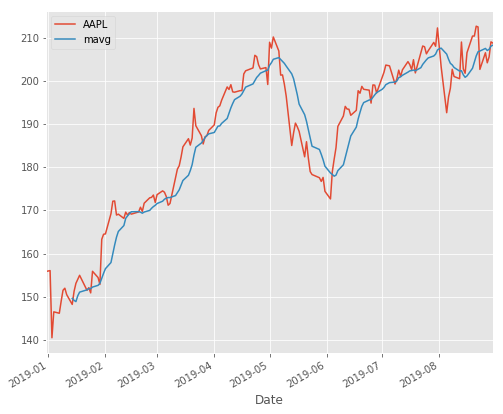

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

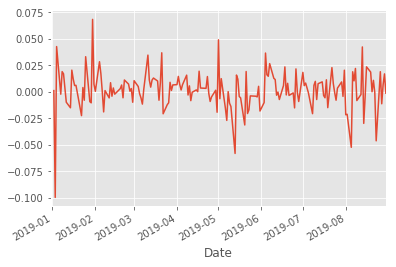

In [3]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [4]:
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df['Close'] - df['Open']) / df['Open'] * 100.0

print (dfreg)

             Adj Close      Volume    HL_PCT  PCT_change
Date                                                    
2018-12-31  155.871613  35003500.0  1.825792   -0.498324
2019-01-02  156.049484  37039700.0  2.925539    1.956226
2019-01-03  140.505798  91312200.0  2.616219   -1.243224
2019-01-04  146.503891  58607100.0  3.203831    2.580776
2019-01-07  146.177811  54777800.0  1.980672   -0.517824
...                ...         ...       ...         ...
2019-08-26  206.490005  26043600.0  1.031529    0.306036
2019-08-27  204.160004  25873300.0  2.458858   -1.780043
2019-08-28  205.529999  15938800.0  1.167710    0.700633
2019-08-29  209.009995  20990500.0  1.272668    0.244602
2019-08-30  208.740005  21143400.0  1.556961   -0.675675

[169 rows x 4 columns]


### preparing Data

In [5]:
# Drop missing value

dfreg.fillna (value=-99999, inplace=True)

# Separate 1% of the data to forecast

forecast_out = 10

# separate label here
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
      
# Separate label and identify it as y

Y = np.array(dfreg['label'])
Y = Y[:-forecast_out]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)


### Scikit Learn modules


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import Lasso


In [7]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, Y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, Y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, Y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, Y_train)

# Lasso model
clflasso = Lasso()
clflasso.fit(X_train, Y_train)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
confidencereg = clfreg.score(X_test, Y_test)
confidencepoly2 = clfpoly2.score(X_test, Y_test)
confidencepoly3 = clfpoly3.score(X_test, Y_test)

confidenceknn = clfknn.score(X_test, Y_test)

confidencelasso = clflasso.score(X_test, Y_test)

print ("Confidence : ")
print (" - Linear      : ",confidencereg)
print (" - Poly2 Ridge : ",confidencepoly2)
print (" - Poly3 Ridge : ",confidencepoly3)
print (" - KNN Model   : ", confidenceknn)
print (" - Lasso Model : ", confidencelasso)


Confidence : 
 - Linear      :  0.7072416533496706
 - Poly2 Ridge :  0.7180860282943495
 - Poly3 Ridge :  0.6928746401841273
 - KNN Model   :  0.5432997508092592
 - Lasso Model :  0.7045656157826801


In [9]:
forecastLinear = clfreg.predict(X_lately)
forecastRidge2 = clfpoly2.predict(X_lately)
forecastRidge3 = clfpoly3.predict(X_lately)
forecastKnn = clfknn.predict(X_lately)
forecastLasso = clflasso.predict(X_lately)

dfreg['Forecast_linear'] = np.nan

print ("Prediction : ")
print (" - Linear      : ", forecastLinear)
print (" - Poly2 Ridge : ", forecastRidge2)
print (" - Poly3 Ridge : ", forecastRidge3)
print (" - KNN Model   : ", forecastKnn)
print (" - Lasso Model : ", forecastLasso)

dfreg.tail(30)

Prediction : 
 - Linear      :  [209.16572416 208.82550242 211.41683432 211.8228884  204.45826785
 205.18150998 206.92128859 206.49091029 208.51881509 209.57945439]
 - Poly2 Ridge :  [205.96015431 204.79776876 209.21664372 205.17074737 211.98963154
 205.41782945 203.30148867 206.30404402 206.02188007 205.32772692]
 - Poly3 Ridge :  [203.55090774 202.25778901 205.80767573 199.04827839 201.65202733
 206.26119261 203.98816995 204.38467339 203.18478774 203.33779886]
 - KNN Model   :  [198.71183014 204.53782654 201.17329407 199.53682709 199.86122894
 205.30963135 205.73537445 207.76062012 200.73500061 201.33503723]
 - Lasso Model :  [207.42372134 207.13722951 209.38680959 209.17554266 199.32871229
 204.49543105 202.88785182 205.01799641 206.88081602 206.68040599]


,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast_linear
Date,,,,,,
2019-07-22,206.435654,22277900.0,1.746933,1.753011,192.608185,NaN
2019-07-23,208.049515,18355200.0,0.775718,0.182284,196.254333,NaN
2019-07-24,207.880173,14991600.0,0.948865,0.481533,198.286606,NaN
2019-07-25,206.236420,13909600.0,1.212448,-0.895206,202.659988,NaN
2019-07-26,206.953690,17618900.0,1.246749,0.125318,200.990005,NaN
2019-07-29,208.886337,21673400.0,1.049216,0.585237,200.479996,NaN
2019-07-30,207.989746,33935700.0,1.365076,0.009582,208.970001,NaN
2019-07-31,212.233627,69281400.0,4.726808,-1.561780,202.750000,NaN
2019-08-01,207.641068,54017900.0,5.416684,-2.557270,201.740005,NaN


In [10]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(30).plot()
dfreg['Forecast'].tail(30).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

NameError: name 'forecast_set' is not defined

In [ ]:
dfreg.tail(10)